In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("C://Users//annal//aim//static//csv//Forbes_Billionaires.csv")

# Определим бизнес цели:
## 1- Прогнозирование места в рейтинге
## 2- Оценка факторов, влияющих на место в рейтинге

# Определим цели технического проекта:
## Построить модель, которая будет прогнозировать место в рейтинге на основе представленных данных об участнике
## Провести анализ данных для выявления важнейших характеристик для прогнозирования

# Проверим выбросы и усредним

In [2]:
numeric_columns = ['Networth', 'Age']
for column in numeric_columns:
    if pd.api.types.is_numeric_dtype(df[column]):  # Проверяем, является ли колонка числовой
        q1 = df[column].quantile(0.25)  # Находим 1-й квантиль (Q1)
        q3 = df[column].quantile(0.75)  # Находим 3-й квантиль (Q3)
        iqr = q3 - q1  # Вычисляем межквантильный размах (IQR)

        # Определяем границы для выбросов
        lower_bound = q1 - 1.5 * iqr  # Нижняя граница
        upper_bound = q3 + 1.5 * iqr  # Верхняя граница

        # Подсчитываем количество выбросов
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_count = outliers.shape[0]

        # Устраняем выбросы: заменяем значения ниже нижней границы на саму нижнюю границу, а выше верхней — на верхнюю
        df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

        print(f"Колонка {column}:")
        print(f"  Есть выбросы: {'Да' if outlier_count > 0 else 'Нет'}")
        print(f"  Количество выбросов: {outlier_count}")
        print(f"  Минимальное значение: {df[column].min()}")
        print(f"  Максимальное значение: {df[column].max()}")
        print(f"  1-й квантиль (Q1): {q1}")
        print(f"  3-й квантиль (Q3): {q3}\n")

Колонка Networth:
  Есть выбросы: Да
  Количество выбросов: 226
  Минимальное значение: 1.0
  Максимальное значение: 9.0
  1-й квантиль (Q1): 1.5
  3-й квантиль (Q3): 4.5

Колонка Age:
  Есть выбросы: Да
  Количество выбросов: 6
  Минимальное значение: 26.5
  Максимальное значение: 100.0
  1-й квантиль (Q1): 55.0
  3-й квантиль (Q3): 74.0



# Превратим номинальные столбцы в числовые

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Определение категориальных признаков для преобразования
categorical_columns = ['Name']

# Инициализация OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop="first")

# Применение OneHotEncoder к выбранным категориальным признакам
encoded_values = encoder.fit_transform(df[categorical_columns])

# Получение имен новых закодированных столбцов
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Преобразование в DataFrame
encoded_values_df = pd.DataFrame(encoded_values, columns=encoded_columns)

# Объединение закодированных значений с оригинальным DataFrame, исключив исходные категориальные столбцы
df = df.drop(columns=categorical_columns)
df = pd.concat([df.reset_index(drop=True), encoded_values_df.reset_index(drop=True)], axis=1)

# Применение Label Encoding для столбца 'Country', 'Source', 'Industry'
label_encoder = LabelEncoder()
df['Country'] = label_encoder.fit_transform(df['Country'])
df['Source'] = label_encoder.fit_transform(df['Source'])
df['Industry'] = label_encoder.fit_transform(df['Industry'])


print(df.head())

   Rank   Networth   Age  Country  Source  Industry  \
0      1       9.0  50.0       70     123         0   
1      2       9.0  58.0       70       5        15   
2      3       9.0  73.0       20      73         3   
3      4       9.0  66.0       70      81        15   
4      5       9.0  91.0       70      11         4   

   Name_Abdulla Al Futtaim & family   \
0                                0.0   
1                                0.0   
2                                0.0   
3                                0.0   
4                                0.0   

   Name_Abdulla bin Ahmad Al Ghurair & family   Name_Abdulsamad Rabiu   \
0                                          0.0                     0.0   
1                                          0.0                     0.0   
2                                          0.0                     0.0   
3                                          0.0                     0.0   
4                                          0.0            

# Создадим выборки данных по параметру места в рейтинге

In [4]:
from sklearn.model_selection import train_test_split

# Выделение признаков (X) и целевой переменной (y)
X = df.drop(columns=['Rank '])  # Признаки
y = df['Rank ']                 # Целевая переменная

# Разделение данных на обучающую и временную выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Разделение временной выборки на контрольную и тестовую выборки
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Проверка размеров выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер контрольной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (1560, 2602)
Размер контрольной выборки: (520, 2602)
Размер тестовой выборки: (520, 2602)


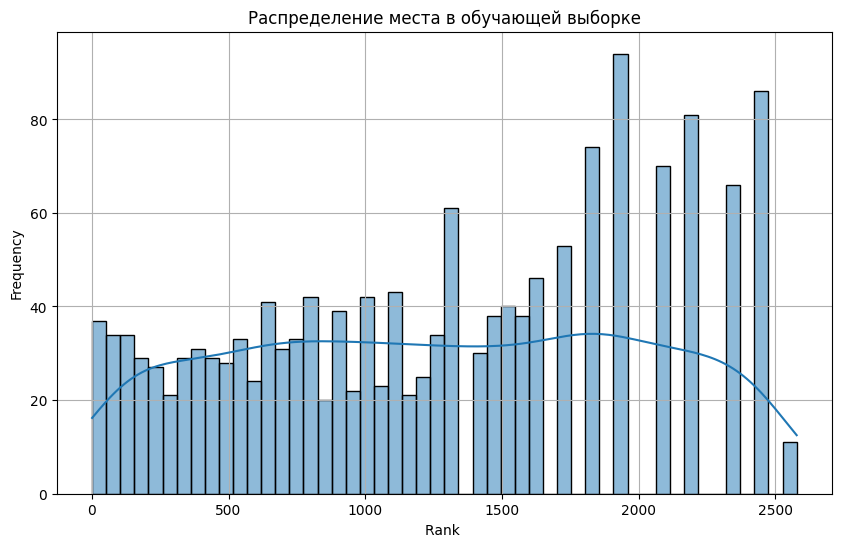

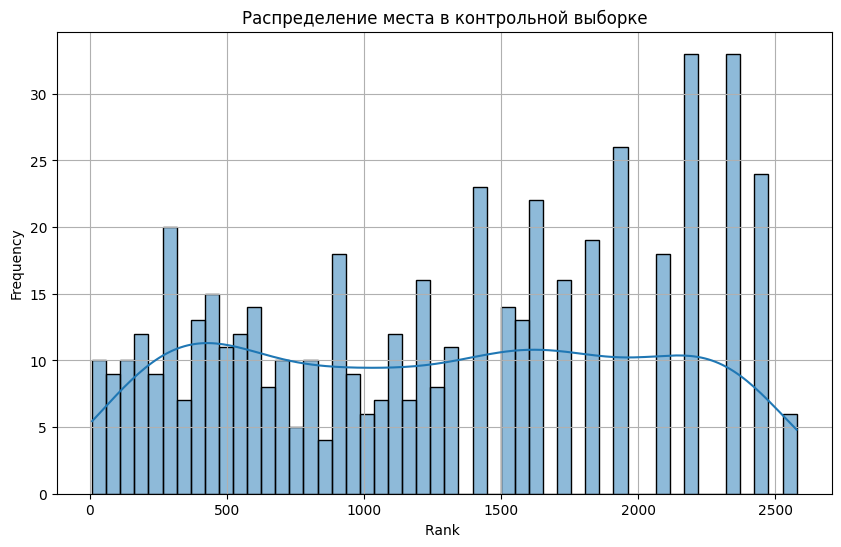

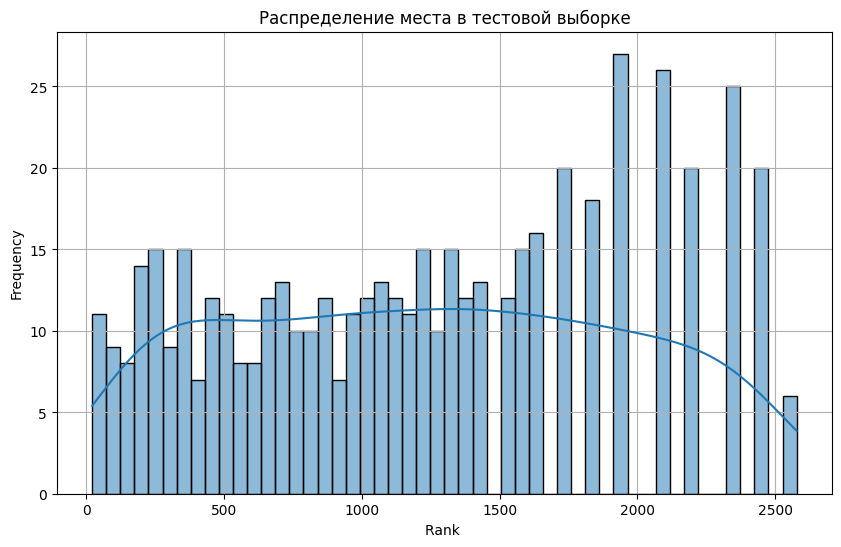

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# Функция для оценки распределения цены
def plot_distribution(y_data, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(y_data, kde=True, bins=50)
    plt.title(title)
    plt.xlabel('Rank ')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Оценка распределения цены в каждой выборке
plot_distribution(y_train, "Распределение места в обучающей выборке")
plot_distribution(y_val, "Распределение места в контрольной выборке")
plot_distribution(y_test, "Распределение места в тестовой выборке")

# Применим min-max нормировку для улучшения качества работы модели

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Предполагаем, что вы уже выделили ваши признаки X
# Применение нормировки Min-Max к всем числовым признакам
min_max_scaler = MinMaxScaler()
X_normalized = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns)

# Применение стандартизации к всем числовым признакам
standard_scaler = StandardScaler()
X_standardized = pd.DataFrame(standard_scaler.fit_transform(X), columns=X.columns)

# Проверка первых 5 строк после нормировки
print("Нормированные данные:")
print(X_normalized.head())

# Проверка первых 5 строк после стандартизации
print("\nСтандартизированные данные:")
print(X_standardized.head())

Нормированные данные:
   Networth       Age   Country    Source  Industry  \
0       1.0  0.319728  0.945946  0.137584  0.000000   
1       1.0  0.428571  0.945946  0.005593  0.882353   
2       1.0  0.632653  0.270270  0.081655  0.176471   
3       1.0  0.537415  0.945946  0.090604  0.882353   
4       1.0  0.877551  0.945946  0.012304  0.235294   

   Name_Abdulla Al Futtaim & family   \
0                                0.0   
1                                0.0   
2                                0.0   
3                                0.0   
4                                0.0   

   Name_Abdulla bin Ahmad Al Ghurair & family   Name_Abdulsamad Rabiu   \
0                                          0.0                     0.0   
1                                          0.0                     0.0   
2                                          0.0                     0.0   
3                                          0.0                     0.0   
4                                   

# Приведём пример использования future tools
## Попробую вынести страну в отдельную таблицу

In [7]:
pip install --upgrade featuretools


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/587.9 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/587.9 kB ? eta -:--:--
   ---------------------------------------- 587.9/587.9 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ---------------------------- ----------- 0.8/1.1 MB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 2.2 MB/s eta 0:00:00


In [8]:
pip install --upgrade setuptools

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------- ----------------------- 0.5/1.3 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import featuretools as ft
from woodwork.logical_types import Categorical, Integer
import pandas as pd
df = pd.read_csv("C://Users//annal//aim//static//csv//Forbes_Billionaires.csv")
df['id'] = pd.Series(range(len(df))) 
# Создание двух таблиц: одна с моделью, другая с остальными данными
country_df = df[['id', 'Country']].drop_duplicates().reset_index(drop=True)
other_df = df.drop(columns=['Country'])

# Создание уникального идентификатора для связи
country_df['country_id'] = country_df.index
other_df['country_id'] = other_df['id'].map(country_df.set_index('id')['country_id'])

es = ft.EntitySet(id="orders")
es = es.add_dataframe(
    dataframe_name="country_table",
    dataframe=country_df,
    index="country_id",  # Индекс для уникальной идентификации моделей
    logical_types={
        "Country": Categorical  # Определяем логический тип для модели
    },
)
es = es.add_dataframe(
    dataframe_name="other_about_billioner",
    dataframe=other_df,
    index="billioner_id",  # Индекс для уникальной идентификации автомобилей
    logical_types={
        "Rank ": Integer,  # Целевая переменная (цена)
        "Networth": Integer,  # Пробег (числовой признак)
        "Age": Integer,
        "country_id": Integer,  # Пробег (числовой признак)
    },
)
es = es.add_relationship("country_table", "country_id", "other_about_billioner", "country_id")

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="other_about_billioner"
)

feature_matrix

c:\Users\annal\aim\.venv\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index billioner_id not found in dataframe, creating new integer column
  warnings.warn(
c:\Users\annal\aim\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\annal\aim\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\annal\aim\.venv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd

Rank   Networth  Age                Industry    id  country_id  \
billioner_id                                                                   
0                 1       219   50             Automotive      0           0   
1                 2       171   58             Technology      1           1   
2                 3       158   73       Fashion & Retail      2           2   
3                 4       129   66             Technology      3           3   
4                 5       118   91  Finance & Investments      4           4   
...             ...       ...  ...                     ...   ...         ...   
2595           2578         1   80             Healthcare   2595        2595   
2596           2578         1   82       Fashion & Retail   2596        2596   
2597           2578         1   71       Fashion & Retail   2597        2597   
2598           2578         1   68       Fashion & Retail   2598        2598   
2599           2578         1   69        Food & Beverage   2599        2599   

              country_table.id country_table.Country  \
billioner_id                                           
0                            0         United States   
1                            1         United States   
2                            2                France   
3                            3         United States   
4                            4         United States   
...                        ...                   ...   
2595                      2595                 Spain   
2596                      2596           Philippines   
2597                      2597           Philippines   
2598                      2598           Philippines   
2599                      2599               Germany   

              country_table.COUNT(other_about_billioner)  \
billioner_id                                               
0                                                      1   
1                                                      1   
2                                                      1   
3                                                      1   
4                                                      1   
...                                                  ...   
2595                                                   1   
2596                                                   1   
2597                                                   1   
2598                                                   1   
2599                                                   1   

              country_table.MAX(other_about_billioner.Age)  ...  \
billioner_id                                                ...   
0                                                     50.0  ...   
1                                                     58.0  ...   
2                                                     73.0  ...   
3                                                     66.0  ...   
4                                                     91.0  ...   
...                                                    ...  ...   
2595                                                  80.0  ...   
2596                                                  82.0  ...   
2597                                                  71.0  ...   
2598                                                  68.0  ...   
2599                                                  69.0  ...   

              country_table.SKEW(other_about_billioner.Rank )  \
billioner_id                                                    
0                                                         NaN   
1                                                         NaN   
2                                                         NaN   
3                                                         NaN   
4                                                         NaN   
...                                                       ...   
2595                                                      NaN   
2596  